# Lesson 6 - Multi-LoRA


In this lesson, we'll see how to efficiently serve dozens of fine-tuned models together in a single deployment without sacrificing latency.

### Import required packages

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

### Let's create a new model

We will start with creating an extension to the model from lesson 5. It has a custom helper function for computing the LoRA layer step with multiple LoRAs per batch.

In [2]:
class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # hidden_size = 10
        # set this so low to ensure we are not 
        # compute-bound by the linear layer
        # this is only an issue when running on CPU, 
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, rank)
        loras_b: torch.Tensor,           # (num_loras, rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        # y[i] = x[i] @ loras_a[lora_idx] @ loras_b[lora_idx]
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices)
        x = self.lm_head(x)
        return x

### Using a loop

Our first attempt to infer across multiple LoRAs will be straightforward: just loop over every row in the batch and apply the correct LoRA using an index mapping: `batch_index --> lora_index`.

In [3]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y

In [4]:
# toy example of a detokenizer. The vocabular only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [5]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [6]:
torch.manual_seed(42)

In [7]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [8]:
model = LoopMultiLoraModel()

### Let's try it!

We will try this over a few random LoRAs using a fixed tensor of input_ids. If our multi-LoRA generation process is working as designed, we should see a variety of different outputs generated as we randomly iterate over the LoRAs.

In [9]:
# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for 64 random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    next_token = generate_token(
        model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices,
    )
    print(next_token)

['orange']
['red']
['chartreuse']
['yellow']
['marigold']
['yellow']
['red']
['orange']
['violet']
['red']


### Let's benchmark our multi-LoRA system!

We will measure the average latency to generate a single token as the batch size increases and each element within the batch can have a different LoRA adapter (chosen randomly).

In [10]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for 
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

**Note:** Your results might differ from those shown in the video, but they will still follow the same pattern.

In [11]:
avg_latencies_loop = benchmark(model)

1 4.033136367797852e-05
2 5.0090789794921876e-05
3 5.8675289154052735e-05
4 6.672525405883789e-05
5 7.773303985595703e-05
6 8.678579330444335e-05
7 9.638166427612305e-05
8 0.00010401058197021485
9 0.0001136178970336914
10 0.00012369155883789061
11 0.00013262128829956055
12 0.0001404433250427246
13 0.0001501617431640625
14 0.00015807390213012695
15 0.0001676607131958008
16 0.00017787694931030275
17 0.00020271825790405272
18 0.00019698333740234374
19 0.00020435476303100585
20 0.0002146291732788086
21 0.00022332477569580078
22 0.00023749732971191405
23 0.00024155950546264648
24 0.00024814224243164065
25 0.0002577028274536133
26 0.00028275489807128907
27 0.0002752170562744141
28 0.00028593969345092773
29 0.0002974438667297363
30 0.00030374431610107424
31 0.00031050491333007815
32 0.00032079505920410155
33 0.00034255790710449217
34 0.00033819818496704104
35 0.00034725236892700195
36 0.0003571619987487793
37 0.00036894512176513674
38 0.0003871002197265625
39 0.0003838229179382324
40 0.000391

### Let's visualize it!

**Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

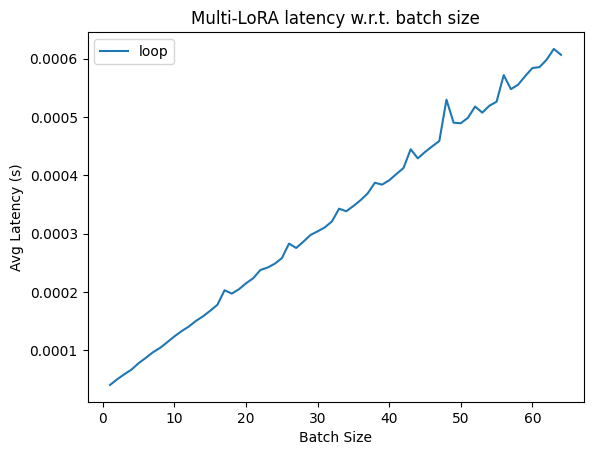

In [12]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

### Let's vectorize the LoRA computation

We will vectorize the LoRA computation by:

1. Gather the LoRA weight for each batch into a single tensor using `torch.index_select`.
2. Apply LoRA computation once for the entire input tensor.

In [13]:
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        
        # gather the LoRA weights into a new tensor and apply
        lora_a = torch.index_select(loras_a, 0, lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, 0, lora_indices) # (batch_size, lora_rank, out_features)
        y += x @ lora_a @ lora_b
        return y

In [14]:
model = GatheredMultiLoraModel()

**Note:** Your results might differ from those shown in the video, but they will still follow the same pattern.

In [15]:
avg_latencies_gathered = benchmark(model)

1 7.071495056152344e-05
2 5.486583709716797e-05
3 5.069637298583984e-05
4 5.865335464477539e-05
5 6.769609451293945e-05
6 6.722545623779297e-05
7 5.618000030517578e-05
8 5.9178829193115234e-05
9 5.924272537231445e-05
10 6.046104431152344e-05
11 6.388235092163086e-05
12 6.261682510375977e-05
13 6.464862823486328e-05
14 6.546640396118164e-05
15 9.006309509277344e-05
16 6.894493103027343e-05
17 7.160615921020508e-05
18 7.257604598999024e-05
19 7.21731185913086e-05
20 7.33046531677246e-05
21 7.552289962768555e-05
22 7.528924942016602e-05
23 8.001279830932618e-05
24 8.007049560546874e-05
25 8.16483497619629e-05
26 8.071708679199219e-05
27 8.342885971069336e-05
28 8.572959899902344e-05
29 8.612251281738281e-05
30 8.570337295532227e-05
31 8.7432861328125e-05
32 9.038543701171875e-05
33 9.258651733398438e-05
34 9.570693969726562e-05
35 9.26060676574707e-05
36 9.454107284545898e-05
37 9.768247604370117e-05
38 0.00012009477615356445
39 0.00012011528015136719
40 0.00012022209167480469
41 0.000125

### Let's visualize it!

**Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

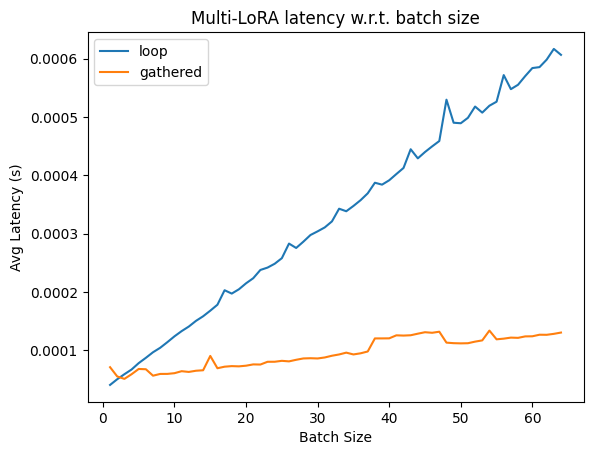

In [16]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()